In [1]:
from pathlib import Path
import shutil

import amici
import amici.petab_import
import amici.petab_objective
from more_itertools import one
import numpy as np
import petab                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             


import petab_timecourse
from petab_timecourse import (
    import_directory_of_componentwise_files,
)

model_name = 'Cuadros_HealthPlace2020'

simulation_duration = 205  # simulated time
output_density = 10  # number of output timepoints per simulated time unit

petab_path = Path(model_name)

componentwise_timecourses_path = petab_path / 'regimens'

In [2]:
petab_yaml_location = str(one(petab_path.glob('*yaml')))
petab_problem = petab.Problem.from_yaml(str(one(petab_path.glob('*yaml'))))

import copy
original_petab_problem = copy.deepcopy(petab_problem)

In [3]:
timecourse_df, condition_df = import_directory_of_componentwise_files(
    componentwise_timecourses_path,
)
petab_problem = petab.Problem.from_yaml(petab_yaml_location)
petab_problem.condition_df = condition_df
petab_problem.timecourse_df = timecourse_df
petab_problem.sbml_model = petab_timecourse.sbml.add_timecourse_as_events(
    petab_problem,
    timecourse_id=one(petab_problem.timecourse_df.index),
)
petab_problem.condition_df = original_petab_problem.condition_df

In [4]:
amici_model = amici.petab_import.import_petab_problem(petab_problem, force_compile=True)

2021-04-15 10:42:13.348 - amici.petab_import - INFO - Importing model ...
2021-04-15 10:42:13.351 - amici.petab_import - INFO - Model name is 'Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio'.
Writing model code to '/home/dilan/Documents/future_annex/petab_chain/github/petab_timecourse/doc/examples/amici_models/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio'.
2021-04-15 10:42:13.352 - amici.petab_import - INFO - Species: 36
2021-04-15 10:42:13.353 - amici.petab_import - INFO - Global parameters: 35
2021-04-15 10:42:13.354 - amici.petab_import - INFO - Reactions: 32
2021-04-15 10:42:13.443 - amici.petab_import - INFO - Observables: 37
2021-04-15 10:42:13.443 - amici.petab_import - INFO - Sigmas: 37
2021-04-15 10:42:13.475 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('noiseParameter1_observable_Cumulative_cases_Counties_neighbouring_counties_with_airports', None), ('noiseParameter1_observable_Cumulati

2021-04-15 10:42:15.674 - amici.ode_export - INFO - Finished writing dwdp.cpp                    ++ (1.97E-01s)
2021-04-15 10:42:15.768 - amici.ode_export - INFO - Finished running smart_jacobian            ++++ (8.62E-02s)
2021-04-15 10:42:15.799 - amici.ode_export - INFO - Finished simplifying dwdx                  ++++ (2.72E-02s)
2021-04-15 10:42:15.799 - amici.ode_export - INFO - Finished computing dwdx                     +++ (1.19E-01s)
2021-04-15 10:42:15.853 - amici.ode_export - INFO - Finished writing dwdx.cpp                    ++ (1.76E-01s)
2021-04-15 10:42:15.914 - amici.ode_export - INFO - Finished running smart_jacobian            ++++ (5.27E-02s)
2021-04-15 10:42:15.928 - amici.ode_export - INFO - Finished simplifying dwdw                  ++++ (4.18E-03s)
2021-04-15 10:42:15.928 - amici.ode_export - INFO - Finished computing dwdw                     +++ (7.00E-02s)
2021-04-15 10:42:15.938 - amici.ode_export - INFO - Finished writing dwdw.cpp                    ++ (8.2

2021-04-15 10:42:17.036 - amici.ode_export - INFO - Finished simplifying ddeltaxdx            +++++ (2.63E-03s)
2021-04-15 10:42:17.041 - amici.ode_export - INFO - Finished simplifying ddeltaxdx            +++++ (2.06E-03s)
2021-04-15 10:42:17.041 - amici.ode_export - INFO - Finished computing ddeltaxdx               ++++ (9.21E-02s)
2021-04-15 10:42:17.207 - amici.ode_export - INFO - Finished running smart_multiply            ++++ (1.61E-01s)
2021-04-15 10:42:17.212 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (5.23E-05s)
2021-04-15 10:42:17.214 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (4.88E-05s)
2021-04-15 10:42:17.216 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (6.78E-05s)
2021-04-15 10:42:17.218 - amici.ode_export - INFO - Finished simplifying ddeltaxdt            +++++ (9.67E-05s)
2021-04-15 10:42:17.220 - amici.ode_export - INFO - Finished simplifying ddeltaxdt            +++++ (9.1

running build_ext
Changed extra_compile_args for unix to ['-fopenmp', '-std=c++14']
building 'Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio._Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio' extension
Testing SWIG executable swig4.0... SUCCEEDED.
swigging swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio.i to swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio_wrap.cpp
swig4.0 -python -c++ -modern -outdir Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio -I/home/dilan/Documents/future_annex/petab_chain/github/petab_timecourse/scratch/venv/lib/python3.8/site-packages/amici/swig -I/home/dilan/Documents/future_annex/petab_chain/github/petab_timecourse/scratch/venv/lib/python3.8/site-packages/amici/include -o swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio_wrap.cpp swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transm

In [7]:
sim = amici.petab_objective.simulate_petab(petab_problem, amici_model)

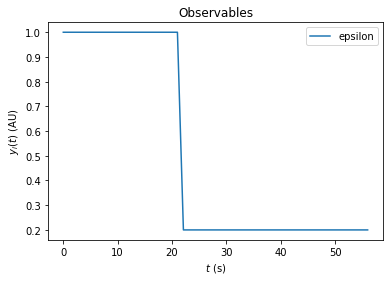

In [8]:
from amici.plotting import plotObservableTrajectories
import matplotlib.pyplot as plt
observable_indices=[amici_model.getObservableIds().index('observable_epsilon')]
plotObservableTrajectories(sim['rdatas'][0], model=amici_model, observable_indices=observable_indices)
plt.show()

In [9]:
from libsbml import formulaToL3String
print('trigger\t\tcomponent\tvalue')
for e in petab_problem.sbml_model.getListOfEvents():
    print(formulaToL3String(e.getTrigger().getMath()), end='\t')
    for a in e.getListOfEventAssignments():
        print(a.getVariable(), end='\t\t')
        print(formulaToL3String(a.getMath()))

trigger		component	value
time >= 1	epsilon		1
time >= 22	epsilon		0.2
time >= 75	epsilon		1


In [10]:
import pypesto.petab
# Import the problem and compile the model.
_importer = pypesto.petab.PetabImporter.from_yaml(petab_yaml_location)
pypesto_problem = _importer.create_problem(force_compile=True)

2021-04-15 10:42:49.148 - amici.petab_import - INFO - Importing model ...
2021-04-15 10:42:49.150 - amici.petab_import - INFO - Model name is 'Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio'.
Writing model code to '/home/dilan/Documents/future_annex/petab_chain/github/petab_timecourse/doc/examples/amici_models/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio'.
2021-04-15 10:42:49.152 - amici.petab_import - INFO - Species: 36
2021-04-15 10:42:49.152 - amici.petab_import - INFO - Global parameters: 35
2021-04-15 10:42:49.153 - amici.petab_import - INFO - Reactions: 32
2021-04-15 10:42:49.224 - amici.petab_import - INFO - Observables: 37
2021-04-15 10:42:49.225 - amici.petab_import - INFO - Sigmas: 37
2021-04-15 10:42:49.263 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict([('noiseParameter1_observable_Cumulative_cases_Counties_neighbouring_counties_with_airports', None), ('noiseParameter1_observable_Cumulati

2021-04-15 10:42:50.982 - amici.ode_export - INFO - Finished running smart_jacobian            ++++ (3.95E-02s)
2021-04-15 10:42:51.015 - amici.ode_export - INFO - Finished simplifying dwdx                  ++++ (3.00E-02s)
2021-04-15 10:42:51.016 - amici.ode_export - INFO - Finished computing dwdx                     +++ (7.61E-02s)
2021-04-15 10:42:51.070 - amici.ode_export - INFO - Finished writing dwdx.cpp                    ++ (1.33E-01s)
2021-04-15 10:42:51.128 - amici.ode_export - INFO - Finished running smart_jacobian            ++++ (5.06E-02s)
2021-04-15 10:42:51.144 - amici.ode_export - INFO - Finished simplifying dwdw                  ++++ (4.85E-03s)
2021-04-15 10:42:51.144 - amici.ode_export - INFO - Finished computing dwdw                     +++ (6.93E-02s)
2021-04-15 10:42:51.159 - amici.ode_export - INFO - Finished writing dwdw.cpp                    ++ (8.61E-02s)
2021-04-15 10:42:51.204 - amici.ode_export - INFO - Finished simplifying xdot                  ++++ (3.5

2021-04-15 10:42:52.023 - amici.ode_export - INFO - Finished computing x_solver                 +++ (2.33E-03s)
2021-04-15 10:42:52.029 - amici.ode_export - INFO - Finished writing x_solver.cpp                ++ (1.06E-02s)
2021-04-15 10:42:52.050 - amici.ode_export - INFO - Finished generating cpp code                  + (2.36E+00s)
2021-04-15 10:43:09.604 - amici.ode_export - INFO - Finished compiling cpp code                   + (1.76E+01s)
2021-04-15 10:43:09.608 - amici.petab_import - INFO - Finished Importing PEtab model                (2.05E+01s)


running build_ext
Changed extra_compile_args for unix to ['-fopenmp', '-std=c++14']
building 'Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio._Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio' extension
Testing SWIG executable swig4.0... SUCCEEDED.
swigging swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio.i to swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio_wrap.cpp
swig4.0 -python -c++ -modern -outdir Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio -I/home/dilan/Documents/future_annex/petab_chain/github/petab_timecourse/scratch/venv/lib/python3.8/site-packages/amici/swig -I/home/dilan/Documents/future_annex/petab_chain/github/petab_timecourse/scratch/venv/lib/python3.8/site-packages/amici/include -o swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transmission_in_Ohio_wrap.cpp swig/Cuadros2020___SIHRD_spatiotemporal_model_of_COVID_19_transm

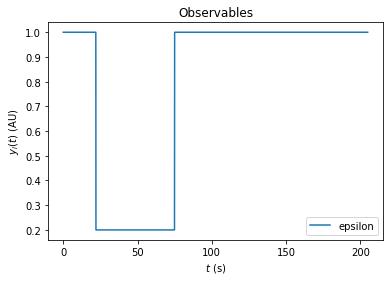

In [11]:
from amici.plotting import plotObservableTrajectories
import matplotlib.pyplot as plt

# Simulate and plot the timecourse parameter.
observable_indices=[pypesto_problem.objective.amici_model.getObservableIds().index('observable_epsilon')]

t = np.linspace(0, simulation_duration, simulation_duration*output_density + 1)
pypesto_problem.objective.amici_model.setTimepoints(t)

par_dict = pypesto_problem.objective.par_arr_to_dct(petab_problem.x_nominal)
ignored_pars = set(par_dict.keys()).difference(pypesto_problem.objective.amici_model.getParameterIds())
pypesto_problem.objective.amici_model.setParameterById({
    k: v
    for k, v in par_dict.items()
    if k not in ignored_pars
})
rdata = amici.runAmiciSimulation(
    pypesto_problem.objective.amici_model,
    pypesto_problem.objective.amici_solver,
)
plotObservableTrajectories(
    rdata,
    model=pypesto_problem.objective.amici_model,
    observable_indices=observable_indices,
)
plt.show()

In [12]:
import pypesto.engine
import pypesto.optimize

optimizer = pypesto.optimize.ScipyOptimizer()
engine = pypesto.engine.MultiProcessEngine()

pypesto_result = pypesto.optimize.minimize(
    problem=pypesto_problem,
    optimizer=optimizer,
    n_starts=16,
    engine=engine,
)

Engine set up to use up to 8 processes in total. The number was automatically determined and might not be appropriate on some systems.
Parameters obtained from history and optimizer do not match: [-0.623407   -1.01614099 -1.98966975 -1.77976589 -2.         -1.72982903
 -1.62699601 -1.74889524 -2.         -2.         -2.         -2.
 -2.          0.         -1.61395472 -2.         -2.         -2.
 -1.81903143 -2.         -1.4106923  -0.96293137 -2.         -1.36300496], [-0.62340668 -1.01630143 -1.98970569 -1.77987778 -2.         -1.72984296
 -1.62703747 -1.7486182  -2.         -2.         -2.         -2.
 -2.          0.         -1.61398504 -2.         -2.         -2.
 -1.81904225 -2.         -1.41064695 -0.96291049 -2.         -1.36293595]
Parameters obtained from history and optimizer do not match: [-0.6235258  -1.01581187 -1.7145388  -2.         -2.         -1.73133023
 -1.62747761 -1.74199532 -2.         -2.         -2.         -2.
 -2.          0.         -1.61751811 -2.         -

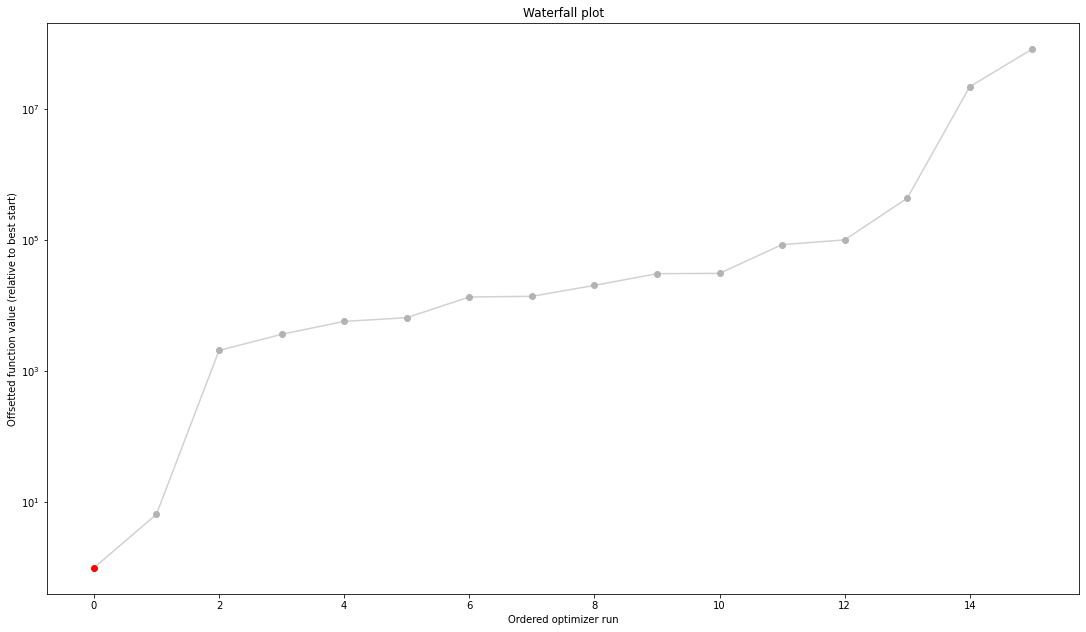

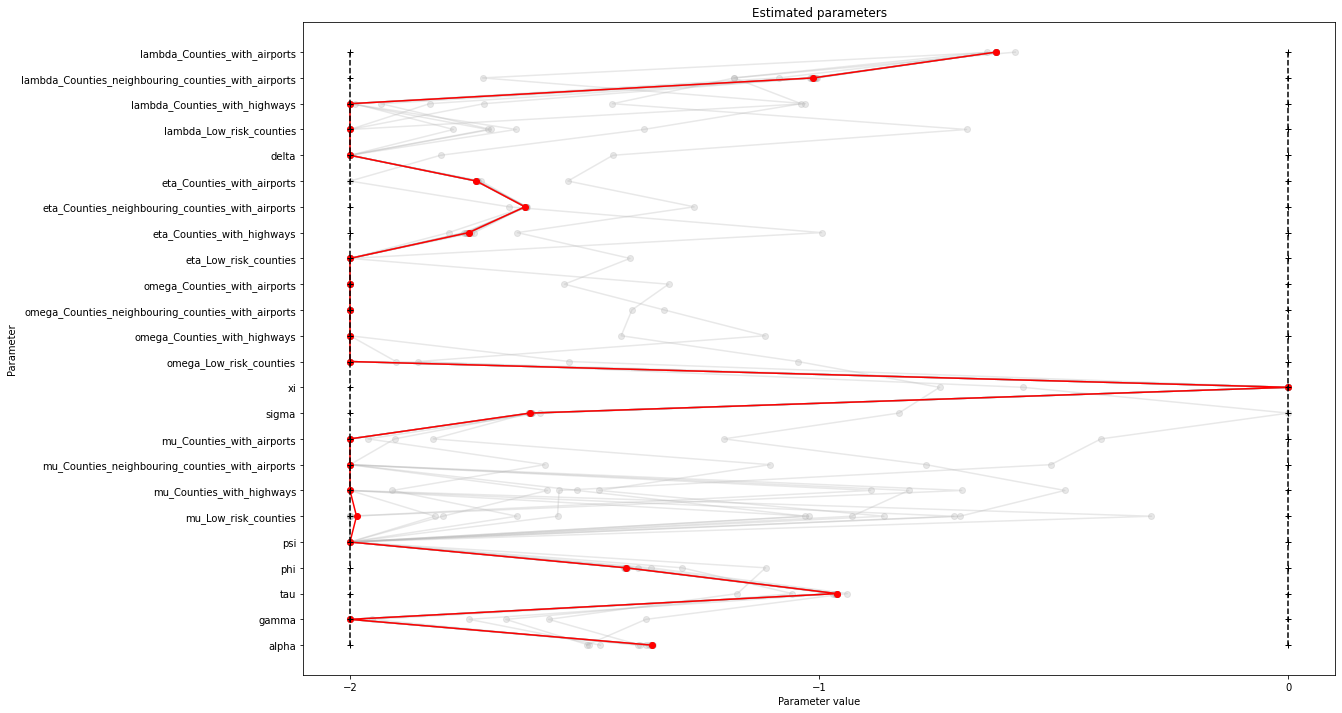

In [13]:
import pypesto.visualize
import matplotlib.pyplot as plt
# Plot optimization information.
pypesto.visualize.waterfall(pypesto_result)
pypesto.visualize.parameters(pypesto_result)
plt.show()

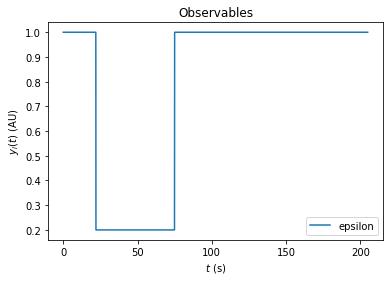

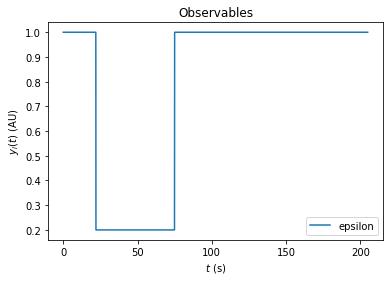

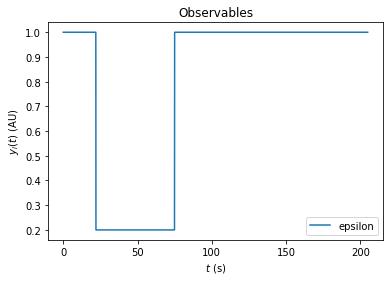

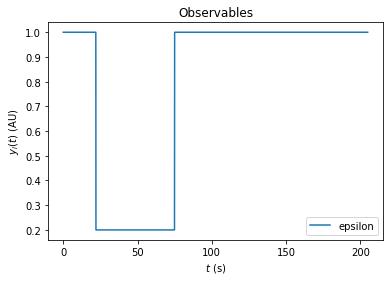

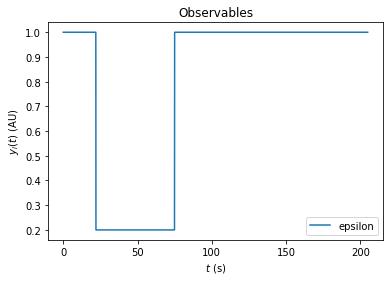

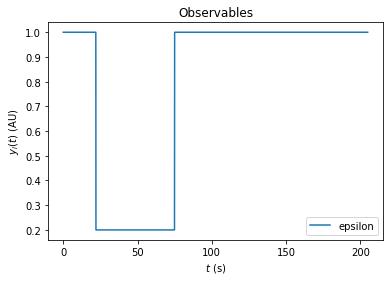

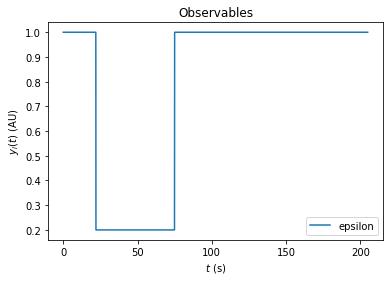

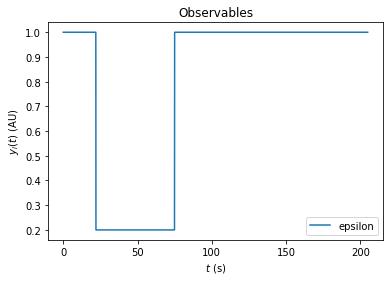

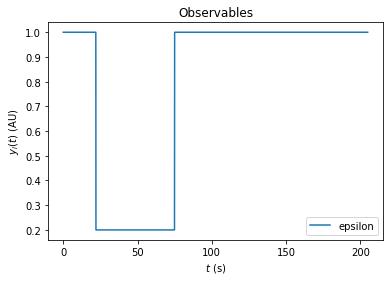

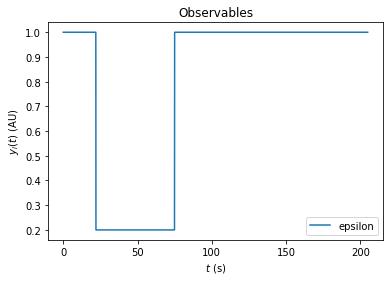

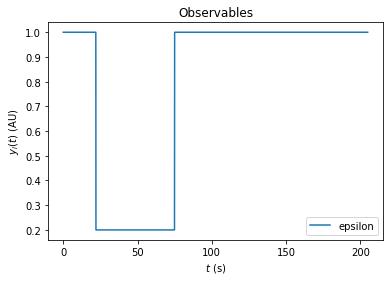

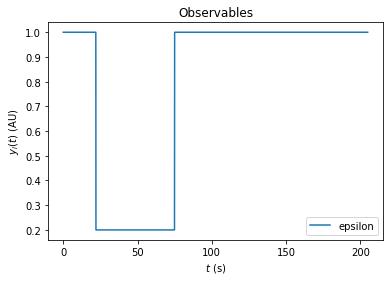

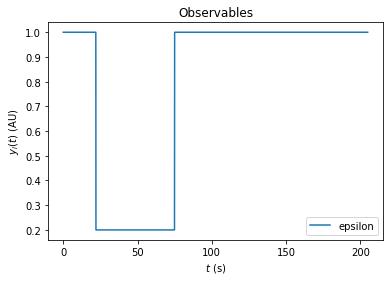

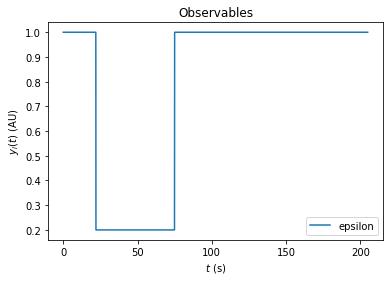

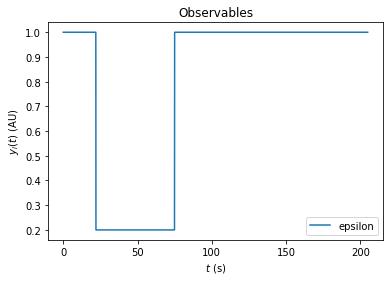

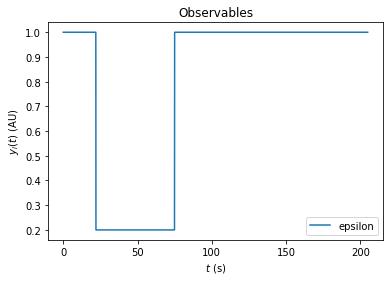

In [14]:
# Simulate and plot the MLE
from amici.plotting import plotStateTrajectories, plotObservableTrajectories
import matplotlib.pyplot as plt
t = np.linspace(0, simulation_duration, simulation_duration*output_density + 1)
pypesto_problem.objective.amici_model.setTimepoints(t)
for start in pypesto_result.optimize_result.list:
    par_dict = pypesto_problem.objective.par_arr_to_dct(np.power(10, start['x']))
    ignored_pars = set(par_dict.keys()).difference(pypesto_problem.objective.amici_model.getParameterIds())
    pypesto_problem.objective.amici_model.setParameterById({
        k: v
        for k, v in par_dict.items()
        if k not in ignored_pars
    })
    #pypesto_problem.objective.amici_model.setParameters(
    #    np.power(10, start['x']),
    #)
    #solver = model.getSolver()
    rdata = amici.runAmiciSimulation(
        pypesto_problem.objective.amici_model,
        pypesto_problem.objective.amici_solver,
    )
     
    #plotStateTrajectories(rdata, model=pypesto_problem.objective.amici_model)
    plotObservableTrajectories(
        rdata,
        model=pypesto_problem.objective.amici_model,
        observable_indices=observable_indices,
    )
    #plt.plot(t, [get_expected_x(t_i) for t_i in t])
    plt.show()

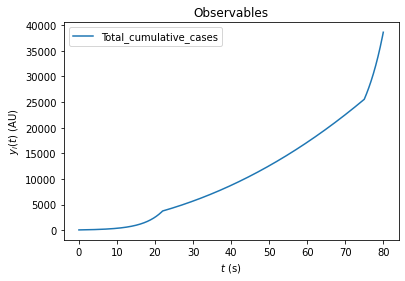

In [15]:
#print(pypesto_problem.objective.amici_model.getObservableIds())
for start in pypesto_result.optimize_result.list[:1]:
    observable_indices=[pypesto_problem.objective.amici_model.getObservableIds().index('observable_Total_cumulative_cases')]
    par_dict = pypesto_problem.objective.par_arr_to_dct(np.power(10, start['x']))
    ignored_pars = set(par_dict.keys()).difference(pypesto_problem.objective.amici_model.getParameterIds())
    pypesto_problem.objective.amici_model.setParameterById({
        k: v
        for k, v in par_dict.items()
        if k not in ignored_pars
    })
    #pypesto_problem.objective.amici_model.setParameters(
    #    np.power(10, start['x']),
    #)
    #solver = model.getSolver()
    pypesto_problem.objective.amici_model.setTimepoints(np.linspace(0, 80, 801))
    rdata = amici.runAmiciSimulation(
        pypesto_problem.objective.amici_model,
        pypesto_problem.objective.amici_solver,
    )
     
    #plotStateTrajectories(rdata, model=pypesto_problem.objective.amici_model)
    fig, ax = plt.subplots()
    plotObservableTrajectories(
        rdata,
        model=pypesto_problem.objective.amici_model,
        observable_indices=observable_indices,
        ax=ax,
    )
    #ax.set_yscale('log')
    #plt.plot(t, [get_expected_x(t_i) for t_i in t])
    plt.show()

In [16]:
pypesto_problem.objective.check_grad_multi_eps(x=petab_problem.x_nominal_free)

,grad,fd_f,fd_b,fd_c,fd_err,abs_err,rel_err,eps
0,-3.898817e+08,-3.899040e+08,-3.898593e+08,-3.898817e+08,44670.581818,0.507052,1.300527e-09,0.00001
1,-2.204627e+08,-2.204716e+08,-2.204538e+08,-2.204627e+08,17870.903015,2.437781,1.105757e-08,0.00001
2,-4.052795e+07,-4.052916e+07,-4.052673e+07,-4.052795e+07,2430.343628,1.029653,2.540599e-08,0.00001
3,-1.493142e+07,-1.493178e+07,-1.493104e+07,-1.493141e+07,745.916367,6.640805,4.447540e-07,0.00001
4,3.685623e+08,3.685542e+08,3.685705e+08,3.685623e+08,16269.397736,0.188637,5.118193e-10,0.00001
5,1.355199e+08,1.355187e+08,1.355211e+08,1.355199e+08,2362.060547,2.168556,1.600176e-08,0.00001
6,7.332308e+07,7.332274e+07,7.332342e+07,7.332308e+07,672.531128,1.863937,2.542088e-08,0.00001
7,1.311589e+07,1.311584e+07,1.311593e+07,1.311589e+07,90.742111,1.073413,8.184066e-08,0.00001
8,3.071986e+06,3.071993e+06,3.071976e+06,3.071985e+06,17.838955,1.326659,4.318574e-07,0.00100
9,-1.249280e+06,-1.249697e+06,-1.248862e+06,-1.249280e+06,834.849358,0.405300,3.244268e-07,0.00100
